In [1]:
"""Adapted from https://debuggercafe.com/implementing-deep-autoencoder-in-pytorch/"""
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torchvision
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from PIL import Image
from torchvision.utils import save_image
import os
from scipy.stats import chi2

In [2]:
def generate_signals(shape):
    """generates a noisy signal of a random freuency
    """
    signal = np.zeros(shape)
    row = np.random.randint(0, shape[-1])
    signal[row] = 1
    return signal

def generate_noise_templates(arr, shape):
    """
    returns a normalized noisy version of a given signal
    """
    df = 1
    noise_layers = []
    for i in range(shape[0]):
        noise_layers.append(np.array(chi2.rvs(df, size = shape[0])))
    noise = np.stack(noise_layers)/np.amax(np.stack(noise_layers))
    noisy_signal = arr+noise
    return noisy_signal/np.amax(noisy_signal)

def gen_data(shape):
    x_data, y_data = [], []
    for i in range(100):
        signal = generate_signals(shape)
        y_data.append(signal)
        x_data.append(generate_noise_templates(signal, shape))
    return x_data, y_data

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
def make_dir():
    image_dir = 'Spectograms'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_decoded_image(img, epoch):
    img = img.view(*shape)
    save_image(img, './Sceptrogram{}.png'.format(epoch))

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        feats = len(np.ravel(x_data[0]))
        
        self.enc1 = nn.Conv2d(1,5,(5,5), padding = 2)
        self.enc2 = nn.Conv2d(5,15,(5,5), padding = 2)
        
        self.fc1 = nn.Linear(5*5*15, 100)
        self.fc2 = nn.Linear(100,20)
        self.fc3 = nn.Linear(20,2)
#         self.enc2 = nn.Conv2D(1,1,(3,3))

    def forward(self,x):
        x = F.relu(self.enc1(x))
        print(x.shape)
        x = F.max_pool2d(x, 2,2)
        print(x.shape)
        x = F.relu(self.enc2(x))
        print(x.shape)
        x = F.max_pool2d(x,2,2)
        print(x.shape)
        x = x.view(-1, 5*5*15)
        print(x.shape)
        x = F.relu(self.fc1(x))
        print(x.shape)
        x = F.relu(self.fc2(x))
        print(x.shape)
        x = self.fc3(x)
        print(x.shape)
        return F.log_softmax(x, dim=1)

def test_image_reconstruction(net, testloader):
    for image in testloader:
        img, _ = image
        img = img.to(device)
        img = torch.flatten(img)
        outputs = net(img)
        outputs = outputs.view(*shape)
        save_image(outputs, 'spectrogram.png')
#         plt.imshow(outputs.cpu())
        break

In [11]:
import time
start_time = time.time()

model = Autoencoder()

#DATA
x,y = gen_data((20,20))
tensor_x = torch.Tensor(x_data) 
tensor_y = torch.Tensor(y_data)

my_dataset = TensorDataset(tensor_x,tensor_y) 
trainloader = DataLoader(my_dataset, batch_size = 10, shuffle =True)

epochs = 5
train_losses, test_losses, train_correct, test_correct = [],[],[],[]

for i in range(num_epochs):
    
    trn_corr, tst_corr = 0,0
    
    for b, (x_train, y_train) in enumerate(trainloader):
        b+=1
        print('X_TRAIN',x_train.shape, 'Y_TRAIN',y_train.shape)
        y_pred = model(x_train) #no flattening
        
        loss = criterion(y_pred, y_train)
        predicted = torch.max(y_pred,1)[1]
        batch_corr = (predicted==y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b%100==0:
            print(f'EPOCH: {i}, BATCH: {b}, LOSS: {loss.item()}')
            
    train_loss.append(loss)
    train_correct.append(trn_corr)
    
    #TEST
    with torch.no_grad():
        for b,(x_test, y_test) in enumerate(trainloader):
            y_val = model(x_test)
            
            predicted = torch.max(y_val.data,1)[1]
            tst_corr += (predicted==y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
    
        
        
current_time = time.time()
total - current_times/start_time
print(f'Time passed: {total/60}')

X_TRAIN torch.Size([10, 20, 20]) Y_TRAIN torch.Size([10, 20, 20])


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [5, 1, 5, 5], but got 3-dimensional input of size [10, 20, 20] instead

In [3]:
num_epochs = 50
learning_rate = 6e-3
batch_size = 100

shape = (20,20)
x_data, y_data = gen_data(shape)

# print(x_data[0])
tensor_x = torch.Tensor(x_data) 
tensor_y = torch.Tensor(y_data)

my_dataset = TensorDataset(tensor_x,tensor_y) 
trainloader = DataLoader(my_dataset)
# %%


device = get_device()
device = 'cpu'
print('DEVICE', device)
print(torch.cuda.is_available())

net = Autoencoder()
net.to(device)

make_dir()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())

train_loss = train(net, trainloader, num_epochs)

plt.figure()
plt.plot(train_loss)
plt.title('Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

test_image_reconstruction(net, trainloader)
# %%

# %%

DEVICE cpu
True
torch.Size([1, 5, 20, 20])
torch.Size([1, 5, 10, 10])
torch.Size([1, 15, 10, 10])
torch.Size([1, 15, 5, 5])
torch.Size([1, 375])
torch.Size([1, 100])
torch.Size([1, 20])
torch.Size([1, 2])


C:\Users\dom\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 1, 20, 20])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (2) must match the size of tensor b (20) at non-singleton dimension 3

In [12]:
class CNN(nn.Module):
    def __init(self):
        super(CNN, self).__init__()
        self.con1 = nn.Conv2d(1, 2, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.con2 = nn.Conv2d(2, 4, 5)
        self.fc1 = nn.Linear(4*5*5, 80)
        self.fc2 = nn.Linear(80,50)
        self.fc3 = nn.Linear(50, 2)
         
    def forward(self,x):
        pass
    
    
learning_rate = 1e-3
batch_size = 5
num_epochs = 50

device = get_device()
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(trainloader)
for epoch in num_epochs:
    for i, (image,labels) in enumerate(trainloader):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i%5==0:
            print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch, num_epochs, loss))
    print('Training Finished')
    
    
            

ValueError: optimizer got an empty parameter list

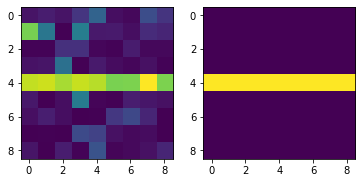

In [46]:
max(np.ravel(gen_noise(shape)))

1.0